In [2]:
import kagglehub
import pandas as pd
import numpy as np
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Download latest version
path = kagglehub.dataset_download("tmdb/tmdb-movie-metadata")
print("Path to dataset files:", path)

# List all files in the downloaded directory
print("\nAvailable files:")
for file in os.listdir(path):
    print(f"  - {file}")

# Load the movies dataset
movies_df = pd.read_csv(os.path.join(path, 'tmdb_5000_movies.csv'))
print(f"\nMovies dataset shape: {movies_df.shape}")
print(f"Movies columns: {list(movies_df.columns)}")

# Load the credits dataset
credits_df = pd.read_csv(os.path.join(path, 'tmdb_5000_credits.csv'))
print(f"\nCredits dataset shape: {credits_df.shape}")
print(f"Credits columns: {list(credits_df.columns)}")

# Display first few rows of movies dataset
print("\nFirst 5 rows of movies dataset:")
print(movies_df.head())

# Merge the two datasets on 'title'
merged_df = pd.merge(movies_df, credits_df, on=['title'], how='left')
print(f"\nMerged dataset shape: {merged_df.shape}")

Path to dataset files: /Users/harrisondolgoff/.cache/kagglehub/datasets/tmdb/tmdb-movie-metadata/versions/2

Available files:
  - tmdb_5000_credits.csv
  - tmdb_5000_movies.csv

Movies dataset shape: (4803, 20)
Movies columns: ['budget', 'genres', 'homepage', 'id', 'keywords', 'original_language', 'original_title', 'overview', 'popularity', 'production_companies', 'production_countries', 'release_date', 'revenue', 'runtime', 'spoken_languages', 'status', 'tagline', 'title', 'vote_average', 'vote_count']

Credits dataset shape: (4803, 4)
Credits columns: ['movie_id', 'title', 'cast', 'crew']

First 5 rows of movies dataset:
      budget                                             genres  \
0  237000000  [{"id": 28, "name": "Action"}, {"id": 12, "nam...   
1  300000000  [{"id": 12, "name": "Adventure"}, {"id": 14, "...   
2  245000000  [{"id": 28, "name": "Action"}, {"id": 12, "nam...   
3  250000000  [{"id": 28, "name": "Action"}, {"id": 80, "nam...   
4  260000000  [{"id": 28, "name": 

In [3]:
# ============ DATA CLEANING ============

# 1. Clean and parse the release_date column
merged_df['release_date'] = pd.to_datetime(merged_df['release_date'], errors='coerce')
merged_df = merged_df.dropna(subset=['release_date'])

# 2. Extract month from release date
merged_df['release_month'] = merged_df['release_date'].dt.month
merged_df['release_year'] = merged_df['release_date'].dt.year

# 3. Clean revenue column - remove rows with 0 or null revenue
merged_df = merged_df[merged_df['revenue'] > 0]
print(f"\nDataset after removing zero revenue: {merged_df.shape}")

# 4. Parse genres column (it's in JSON format)
def parse_genres(genres_str):
    try:
        genres_list = json.loads(genres_str.replace("'", '"'))
        return [genre['name'] for genre in genres_list]
    except:
        return []

merged_df['genres_list'] = merged_df['genres'].apply(parse_genres)

# 5. Explode genres so each movie-genre combination gets its own row
exploded_df = merged_df.explode('genres_list')
exploded_df = exploded_df[exploded_df['genres_list'].notna()]
exploded_df = exploded_df[exploded_df['genres_list'] != '']

print(f"\nUnique genres found: {exploded_df['genres_list'].nunique()}")
print(f"Genres: {sorted(exploded_df['genres_list'].unique())}")


Dataset after removing zero revenue: (3379, 25)

Unique genres found: 19
Genres: ['Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'Foreign', 'History', 'Horror', 'Music', 'Mystery', 'Romance', 'Science Fiction', 'Thriller', 'War', 'Western']


In [4]:
# ============ AGGREGATE DATA FOR HEATMAP ============

# Calculate average revenue by genre and month
genre_month_revenue = exploded_df.groupby(['genres_list', 'release_month'])['revenue'].agg([
    'mean',
    'count'
]).reset_index()

# Filter out genre-month combinations with too few movies (less than 5)
genre_month_revenue = genre_month_revenue[genre_month_revenue['count'] >= 5]

# Pivot to create matrix for heatmap
heatmap_data = genre_month_revenue.pivot(
    index='genres_list', 
    columns='release_month', 
    values='mean'
)

# Fill NaN values with 0 (no movies released in that genre-month combo)
heatmap_data = heatmap_data.fillna(0)

# Convert revenue to millions for better readability
heatmap_data = heatmap_data / 1_000_000

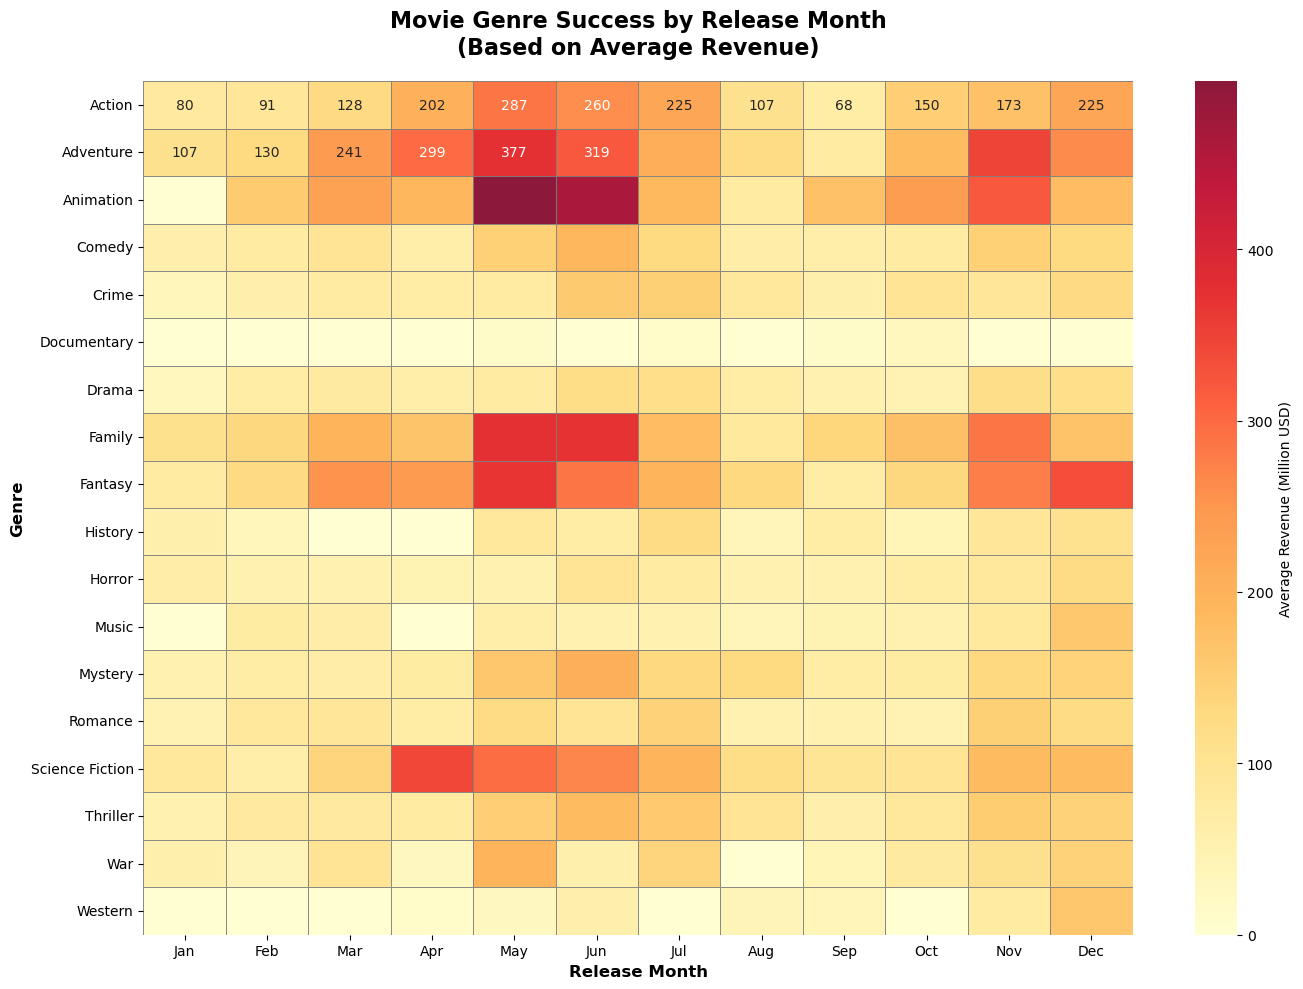

<Figure size 640x480 with 0 Axes>

In [7]:
# ============ CREATE HEATMAP ============

# Set up the plot
plt.figure(figsize=(14, 10))

# Create month labels
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Create heatmap with gradual color changes
sns.heatmap(
    heatmap_data,
    cmap='YlOrRd',  # Yellow to Orange to Red gradient
    annot=True,      # Show values in cells
    fmt='.0f',       # Format as integer
    cbar_kws={'label': 'Average Revenue (Million USD)'},
    xticklabels=month_labels,
    yticklabels=True,
    linewidths=0.5,
    linecolor='gray',
    alpha=0.9
)

plt.title('Movie Genre Success by Release Month\n(Based on Average Revenue)', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Release Month', fontsize=12, fontweight='bold')
plt.ylabel('Genre', fontsize=12, fontweight='bold')

# Rotate y-axis labels for better readability
plt.yticks(rotation=0)
plt.xticks(rotation=0)

plt.tight_layout()

plt.show()
plt.savefig("viz_exports/genre_month_heatmap.png", dpi=150, bbox_inches="tight")